In [44]:
import copy
import pickle
import re
from typing import List
import tqdm

import numpy as np

In [20]:
import openff.interchange
import openff.toolkit

from openff.interchange.components.interchange import Interchange
from openff.toolkit.topology import Topology
from openff.toolkit.typing.engines.smirnoff import ForceField

import openmm
import pandas as pd

In [3]:
print(openff.interchange.__version__)

v0.2.0-alpha.5


In [4]:
print(openff.toolkit.__version__)

0.10.1+102.g57a442b5


In [5]:
from interchange_regression_utilities.models import (
    ComparisonSettings,
    ExpectedValueChange,
    model_from_file,
    TopologyDefinition,
)

In [6]:
models = model_from_file(List[TopologyDefinition], "input-topologies.json")

In [10]:
topologies = []
failed_smiles = []
smiles_pattern = "SMILES '([A-Za-z0-9=\(\)\[\]]+)'"
for model in tqdm.tqdm(models):
    try:
        topologies.append(model.to_topology())
    except ValueError as e:
        if "No registered toolkits can provide the capability" in str(e):
            smiles = re.search(smiles_pattern, str(e)).group(1)
            failed_smiles.append(smiles)

 51%|█████████████████████▉                     | 26/51 [08:11<10:04, 24.20s/it]Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral:

In [15]:
len(failed_smiles)

0

In [16]:
topology_file = "openff_topologies.pkl"
with open(topology_file, "wb") as f:
    pickle.dump(topologies, f)
# with open(topology_file, "rb") as f:
#     topologies = pickle.load(f)

In [17]:
force_field = ForceField("openff-2.0.0.offxml")

In [18]:
interchanges = [
    Interchange.from_smirnoff(force_field, topology)
    for topology in tqdm.tqdm(topologies)
]

interchange_systems = [
    ichange.to_openmm(combine_nonbonded_forces=True)
    for ichange in interchanges
]

100%|███████████████████████████████████████████| 51/51 [00:09<00:00,  5.20it/s]


In [19]:
toolkit_systems = [
    force_field.create_openmm_system(topology, use_interchange=False)
    for topology in tqdm.tqdm(topologies)
]

 51%|█████████████████████▉                     | 26/51 [08:27<10:39, 25.57s/it]Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 4, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False

 67%|████████████████████████████▋              | 34/51 [10:30<04:03, 14.34s/it]Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 7, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: True, chiral: False
bond order: 

In [24]:
def get_charges(
    system,
    model_index: int = 0,
    version: str = "interchange",
) -> pd.DataFrame:
    force = [
        force for force in system.getForces()
        if "NonbondedForce" in str(type(force))
    ][0]
    
    name = models[model_index].name
    data = {"particle_index": [], "charge": []}
    for i in range(force.getNumParticles()):
        charge, *_ = force.getParticleParameters(i)
        data["particle_index"].append(i)
        data["charge"].append(charge._value)
    
    df = pd.DataFrame(data)
    df["name"] = name
    df["version"] = version
    return df

In [69]:
all_charge_dfs = []

for i, (ichange, toolkit) in tqdm.tqdm(
    list(enumerate(zip(interchange_systems, toolkit_systems)))
):
    model = models[i]
    
    name = model.name
    ixml = openmm.XmlSerializer.serialize(ichange)
    txml = openmm.XmlSerializer.serialize(toolkit)
    
    ichange_name = f"interchange-{openff.interchange.__version__}"
    toolkit_name = f"toolkit-{openff.toolkit.__version__}"
    ifile = f"xmls/{name}_{ichange_name}.xml"
    tfile = f"xmls/{name}_{toolkit_name}.xml"
    
    with open(ifile, "w") as f:
        f.write(ixml)
    with open(tfile, "w") as f:
        f.write(txml)
        
    idf = get_charges(ichange, model_index=i, version=ichange_name)
    tdf = get_charges(toolkit, model_index=i, version=toolkit_name)
    
    model_df = copy.deepcopy(tdf)
    model_df["version"] = "original_topology_v0.11"
    model_df["charge"] = [
        charge
        for molecule in topologies[i].topology_molecules
        for charge in np.array(molecule.partial_charges)
    ]
    
#     topology2 = model.to_topology()
#     model_df2 = pd.DataFrame(tdf)
#     model_df2["version"] = "new_topology"
#     model_df2["charge"] = [
#         charge._value
#         for molecule in topologies[i].topology_molecules
#         for charge in molecule.partial_charges
#     ]
    
    
    all_charge_dfs.extend(
        [idf, tdf, model_df,
#          model_df2,
    ])

charge_df = pd.concat(all_charge_dfs)

  0%|                                                    | 0/51 [00:00<?, ?it/s]/Users/lily/pydev/toolkit/openff/toolkit/topology/topology.py:51: TopologyDeprecationWarning: Topology.topology_molecules is deprecated. Use Topology.molecules instead.
  warnings.warn(
/var/folders/rv/j6lbln6j0kvb5svxj8wflc400000gn/T/ipykernel_40801/2742637082.py:30: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  for charge in np.array(molecule.partial_charges)
/Users/lily/pydev/toolkit/openff/toolkit/topology/topology.py:51: TopologyDeprecationWarning: Topology.topology_molecules is deprecated. Use Topology.molecules instead.
  warnings.warn(
/var/folders/rv/j6lbln6j0kvb5svxj8wflc400000gn/T/ipykernel_40801/2742637082.py:30: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  for charge in np.array(molecule.partial_charges)
/Users/lily/pydev/toolkit/openff/toolkit/topology/topology.py:51: TopologyDeprecationWarning: Topology.top

 51%|█████████████████████▍                    | 26/51 [00:00<00:00, 127.84it/s]/Users/lily/pydev/toolkit/openff/toolkit/topology/topology.py:51: TopologyDeprecationWarning: Topology.topology_molecules is deprecated. Use Topology.molecules instead.
  warnings.warn(
/var/folders/rv/j6lbln6j0kvb5svxj8wflc400000gn/T/ipykernel_40801/2742637082.py:30: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  for charge in np.array(molecule.partial_charges)
/Users/lily/pydev/toolkit/openff/toolkit/topology/topology.py:51: TopologyDeprecationWarning: Topology.topology_molecules is deprecated. Use Topology.molecules instead.
  warnings.warn(
/var/folders/rv/j6lbln6j0kvb5svxj8wflc400000gn/T/ipykernel_40801/2742637082.py:30: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  for charge in np.array(molecule.partial_charges)
/Users/lily/pydev/toolkit/openff/toolkit/topology/topology.py:51: TopologyDeprecationWarning: Topology.top

100%|██████████████████████████████████████████| 51/51 [00:00<00:00, 124.90it/s]


In [70]:
charge_df.version.unique()

array(['interchange-v0.2.0-alpha.5', 'toolkit-0.10.1+102.g57a442b5',
       'original_topology_v0.11'], dtype=object)

In [56]:
ichange_df = charge_df[charge_df["version"] == "interchange-v0.2.0-alpha.5"]
toolkit_df = charge_df[charge_df["version"] == "toolkit-0.10.1+102.g57a442b5"]
topology_df = charge_df[charge_df["version"] == "original_topology"]

In [50]:
max(ichange_df.charge - toolkit_df.charge)

0.0

In [52]:
max(topology_df.charge - topology_df.charge)

0.0

In [71]:
charge_df.to_csv("charges_v011.csv")

In [72]:
older = pd.read_csv("charges_v010.csv", index_col=0)

In [73]:
combined = pd.concat([charge_df, older])

In [74]:
combined

,particle_index,charge,name,version
0,0,-0.91150,0,interchange-v0.2.0-alpha.5
1,1,0.16355,0,interchange-v0.2.0-alpha.5
2,2,0.02260,0,interchange-v0.2.0-alpha.5
3,3,-0.08142,0,interchange-v0.2.0-alpha.5
4,4,-0.10215,0,interchange-v0.2.0-alpha.5
...,...,...,...,...
45,45,0.15917,50,original_topology_v0.10
46,46,0.15954,50,original_topology_v0.10
47,47,0.03068,50,original_topology_v0.10
48,48,0.07602,50,original_topology_v0.10


In [75]:
openmm_from_interchange_v02 = combined[combined["version"] == "interchange-v0.2.0-alpha.5"]
openmm_from_toolkit_v011 = combined[combined["version"] == "toolkit-0.10.1+102.g57a442b5"]
toolkit_v011 = combined[combined["version"] == "original_topology_v0.11"]
openmm_from_interchange_v01 = combined[combined["version"] == "interchange-v0.1.4"]
toolkit_v010 = combined[combined["version"] == "original_topology_v0.10"]

## General differences

| **Version**                    | **Charge method**                 | **Interchange** | **Toolkit**                              |
|--------------------------------|-----------------------------------|-----------------|------------------------------------------|
| `interchange-v0.2.0-alpha.5`   | `Interchange.to_openmm`           | v0.2.0-alpha.5  | `topology-biopolymer-refactor`  pre-1276 |
| `toolkit-0.10.1+102.g57a442b5` | `ForceField.create_openmm_system` | v0.2.0-alpha.5  | `topology-biopolymer-refactor`  pre-1276 |
| `original_topology_v0.11`      | `Molecule.assign_partial_charges` | v0.2.0-alpha.5  | `topology-biopolymer-refactor`  pre-1276 |
| `interchange-v0.1.4`           | `Interchange.to_openmm`           | v0.1.4          | v0.10.6                                  |
| `original_topology_v0.10`      | `Molecule.assign_partial_charges` | v0.1.4          | v0.10.6                                  |

In [89]:
versions = list(combined.version.unique())
n_versions = len(versions)
differences = np.zeros((n_versions, n_versions))
for i, ver1 in enumerate(versions):
    a = combined[combined.version == ver1]
    for j, ver2 in enumerate(versions[i + 1:], i + 1):
        b = combined[combined.version == ver2]
        diff = abs(a.charge.values - b.charge.values)
        differences[i, j] = differences[j, i] = max(diff)
        

<AxesSubplot:>

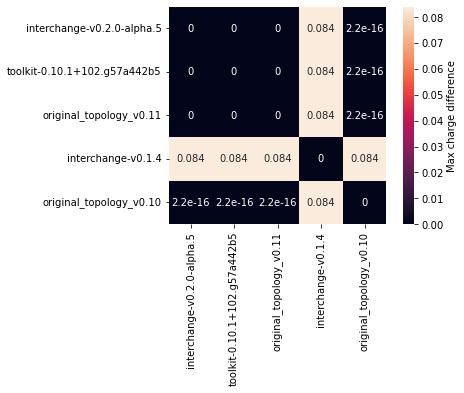

In [88]:
import seaborn as sns

sns.heatmap(
    differences,
    xticklabels=versions,
    yticklabels=versions,
    square=True,
    annot=True,
    cbar_kws={"label": "Max charge difference"}
)

In [91]:
openmm_from_interchange_v01["difference"] = abs(
    openmm_from_interchange_v01.charge.values - openmm_from_interchange_v02.charge.values
)

/var/folders/rv/j6lbln6j0kvb5svxj8wflc400000gn/T/ipykernel_40801/1637653651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openmm_from_interchange_v01["difference"] = abs(


In [94]:
openmm_from_interchange_v01.groupby("name").max()

,particle_index,charge,version,difference
name,,,,
0,36,0.77009,interchange-v0.1.4,0.02945
1,49,0.75212,interchange-v0.1.4,0.03363
2,51,0.76027,interchange-v0.1.4,0.04014
3,49,0.64171,interchange-v0.1.4,0.01015
4,36,0.75695,interchange-v0.1.4,0.04224
5,48,1.43489,interchange-v0.1.4,0.00911
6,46,0.72579,interchange-v0.1.4,0.02239
7,44,1.46257,interchange-v0.1.4,0.01095
8,50,1.42785,interchange-v0.1.4,0.00655
